<h1>INTRODUCTION</h1>
Using the inceptionV3 Architecture for image classification. The cat vs Dog image was use for training the model. The inceptionv3 model was used as the base model with the layers in it set as trainable.

In [6]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers, Model, Sequential, models
import tensorflow_datasets as tfds
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten
from tensorflow.keras.models import Model

In [24]:
#create base model 
Inception = tf.keras.applications.InceptionV3(include_top=False,
                        input_shape=(180, 180, 3),
                        weights="imagenet",
                        pooling='max'
                        )

for layer in Inception.layers:
  layer.trainable=True


In [86]:
#define parameter
units = [512, 256]
activations = ['relu', 'relu', ]
out_activation = 'sigmoid'
num_class = 2
Architecture = Inception

OPTIMIZER=tf.keras.optimizers.Adam(learning_rate=0.001)
LOSS=tf.keras.losses.SparseCategoricalCrossentropy()
METRICS=['Accuracy']
EPOCHS=10

In [42]:
#image processing function
def img_process(features):
   
    image = tf.image.resize(features['image'], (180, 180))
    image = tf.cast(image, 'float32')/255.
    label = features['label']
    return image, label

def test_img_process(features):
   
    image = tf.image.resize(features['image'], (180, 180))
    image = tf.cast(image, 'float32')/255.
    return image



In [88]:
#download dataset
train_ds, test_ds, val_ds, pred_ds = tfds.load('cats_vs_dogs', 
                                               split=['train[:60%]', 
                                                      'train[60%:80%]', 
                                                      'train[80%:95%]', 
                                                      'train[95%:]'
                                                      ], 
                                               download=True,
                                               shuffle_files=True
                                               )


train_ds = train_ds.map(img_process, num_parallel_calls=tf.data.AUTOTUNE)\
                  .batch(64, drop_remainder=True)\
                  .cache()\
                  .prefetch(tf.data.AUTOTUNE)

val_ds = val_ds.map(img_process, num_parallel_calls=tf.data.AUTOTUNE)\
                .batch(64, drop_remainder=True)\
                .cache()\
                .prefetch(tf.data.AUTOTUNE)

test_ds = test_ds.map(img_process, num_parallel_calls=tf.data.AUTOTUNE)\
                  .batch(64, drop_remainder=True)\
                  .cache()\
                  .prefetch(tf.data.AUTOTUNE)

pred_ds = pred_ds.map(test_img_process, num_parallel_calls=tf.data.AUTOTUNE)\
                  .batch(64, drop_remainder=True)\
                  .cache()\
                  .prefetch(tf.data.AUTOTUNE)


In [27]:
#name the class label
LABEL_NAMES = ['CAT', 'DOG']

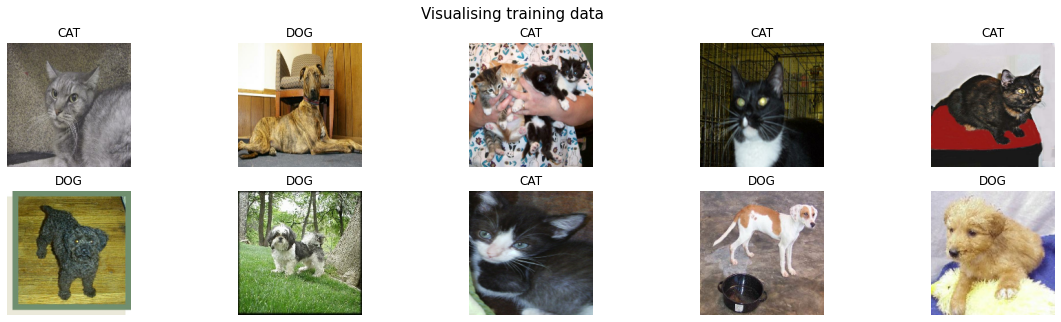

In [48]:
#plot some images 
f, ax = plt.subplots(2, 5, figsize=(20,5))
for images, label in train_ds.take(1):
  for i in range(5):
    f.suptitle("Visualising training data", fontsize=15)
    ax[0,i].set_title(LABEL_NAMES[label[i+5].numpy()])
    ax[0,i].imshow(images[i+5,:,:,:])
    ax[0,i].axis("off")
for i in range(5):
  ax[1,i].set_title(LABEL_NAMES[label[i+15].numpy()]) 
  ax[1,i].imshow(images[i+15,:,:,:])
  ax[1,i].axis("off")
plt.show()

In [29]:
#define model using subclassing model method

class model_1(keras.Model):
    def __init__(self, units, activations, out_activation, Architecture, num_class):
        super(model_1, self).__init__()
        
        self.units = units
        self.activations = activations
        self.out_activation = out_activation
        self.Architecture = Architecture
        self.num_class = num_class


        self.flatten_1 = layers.Flatten(name='flatten'
                                     )
        
        self.Dense_1 = layers.Dense(self.units[0],
                                  activation=self.activations[0],
                                  name='Dense_1'
                                  )
        
        self.Dense_2 = layers.Dense(self.units[1],
                                  activation=self.activations[1],
                                  name='Dense_2'
                                  )
        
        self.out_layer = layers.Dense(self.num_class,
                                      activation=self.out_activation,
                                      name='out_layer'
                                      )
        
    def call(self, inputs):

        x = Architecture(inputs)
        x = self.Dense_1(x)
        x = self.Dense_2(x)

        return self.out_layer(x)
        

In [30]:
#initiate model
model = model_1(units, activations, out_activation, Architecture, num_class)

In [35]:
#compile model
model.compile(optimizer=OPTIMIZER,
              loss=LOSS,
              metrics=METRICS)

In [44]:
#fit and train model
history = model.fit(train_ds, 
                    epochs=EPOCHS,
                    validation_data=val_ds)

Epoch 1/10
218/218 [==============================] - 24s 109ms/step - loss: 0.0259 - Accuracy: 0.9910 - val_loss: 0.0679 - val_Accuracy: 0.9803
Epoch 2/10
218/218 [==============================] - 23s 105ms/step - loss: 0.0262 - Accuracy: 0.9895 - val_loss: 0.0819 - val_Accuracy: 0.9766
Epoch 3/10
218/218 [==============================] - 23s 104ms/step - loss: 0.0305 - Accuracy: 0.9880 - val_loss: 0.0706 - val_Accuracy: 0.9797
Epoch 4/10
218/218 [==============================] - 23s 105ms/step - loss: 0.0340 - Accuracy: 0.9870 - val_loss: 0.0693 - val_Accuracy: 0.9780
Epoch 5/10
218/218 [==============================] - 23s 105ms/step - loss: 0.0283 - Accuracy: 0.9892 - val_loss: 0.0885 - val_Accuracy: 0.9766
Epoch 6/10
218/218 [==============================] - 23s 105ms/step - loss: 0.0264 - Accuracy: 0.9897 - val_loss: 0.0934 - val_Accuracy: 0.9783
Epoch 7/10
218/218 [==============================] - 23s 104ms/step - loss: 0.0270 - Accuracy: 0.9900 - val_loss: 0.1069 - val_Ac

Text(0.5, 1.0, 'Training and Validation accuracy')

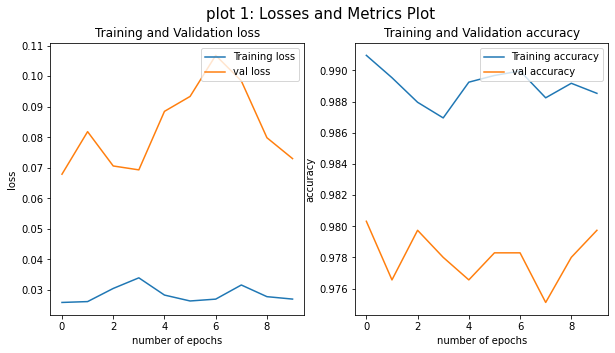

In [45]:
### Plot the losses and metrics. Comment on the figures in your report, with
### regard to how the training has proceeded.

import matplotlib.pyplot as plt

loss = history.history['loss']

accuracy = history.history['Accuracy']

val_loss = history.history['val_loss']
val_accuracy = history.history['val_Accuracy']


epochs_range = range(EPOCHS)
plt.figure(figsize=(10,5))
plt.suptitle("plot 1: Losses and Metrics Plot", fontsize=15)
plt.subplot(1, 2, 1)
plt.plot(epochs_range, loss, label='Training loss')
plt.plot(epochs_range, val_loss, label='val loss')
plt.xlabel('number of epochs')
plt.ylabel('loss')
plt.legend(loc='upper right')
plt.title('Training and Validation loss')
plt.subplot(1, 2, 2)
plt.plot(epochs_range, accuracy, label='Training accuracy')
plt.plot(epochs_range, val_accuracy, label='val accuracy')
plt.xlabel('number of epochs')
plt.ylabel('accuracy')
plt.legend(loc='upper right')
plt.title('Training and Validation accuracy')

In [83]:
#evaluate model on test_ds
loss, accuracy = model.evaluate(test_ds)
print(' The Model Accuracy Score is ', f'{accuracy*100 :.2f}')

72/72 [==============================] - 6s 77ms/step - loss: 0.0588 - Accuracy: 0.9818
 The Model Accuracy Score is  98.18


In [47]:
#predicted labels
y_pred = model.predict(pred_ds)
y_pred = np.argmax(y_pred, 1)

18/18 [==============================] - 3s 78ms/step


 The Model Accuracy Score is  98.18


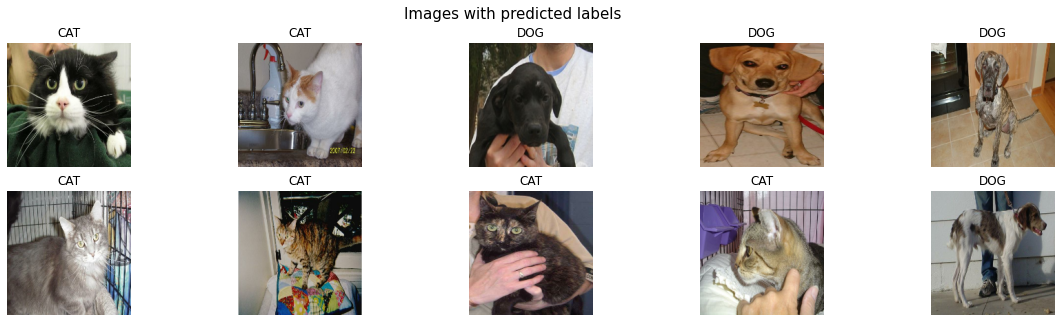

In [87]:
#model accurray
print(' The Model Accuracy Score is ', f'{accuracy*100 :.2f}')

#plot of images using the predicted labels
f, ax = plt.subplots(2, 5, figsize=(20,5))
for images in pred_ds.take(1):
  for i in range(5):
    f.suptitle("Images with predicted labels", fontsize=15)
    ax[0,i].set_title(LABEL_NAMES[y_pred[i]])
    ax[0,i].imshow(images[i,:,:,:])
    ax[0,i].axis("off")
for i in range(5):
  ax[1,i].set_title(LABEL_NAMES[y_pred[i+15]]) 
  ax[1,i].imshow(images[i+15,:,:,:])
  ax[1,i].axis("off")
plt.show()